In [98]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt

In [99]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [100]:
pars.set_matter_power(redshifts=[0.2], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [101]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

In [102]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [103]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

Derivata composta della distanza cìdi luminosità

dr/dz =  c/H

dl = (1+z)*r 

dl'= r + (1+z)*c/H

In [104]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!

f = (results.get_fsigma8()/results.get_sigma8())
dl = results.luminosity_distance(z[0])
d= results.comoving_radial_distance(z[0])
 #la calcola alla z scelta già, UNITà DI MISURA

fl= (2*dl/(1+z[0]))/(d+(1+z[0])*3e5/H(z[0]))*f

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [105]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = float((bias + fl * mu[j]**2)**2*pk[:,i])


In [106]:
#Dati per la funzione teorica

om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.36698336647524277

In [107]:
print(fl)
print(omz**0.545)

[0.17103144]
0.5790716151387223


In [108]:
##Errori dei dati simulati
ng= 15e-4   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol*1/(2*np.pi)**2 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [109]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.012153651966884437

In [110]:
#faccio una trasformata di fuorier: considero il volume del guscio sferico come il volume di un cubo

Diag = np.sqrt(3) * (64)**(1/3)
2*np.pi/Diag

0.906899682117109

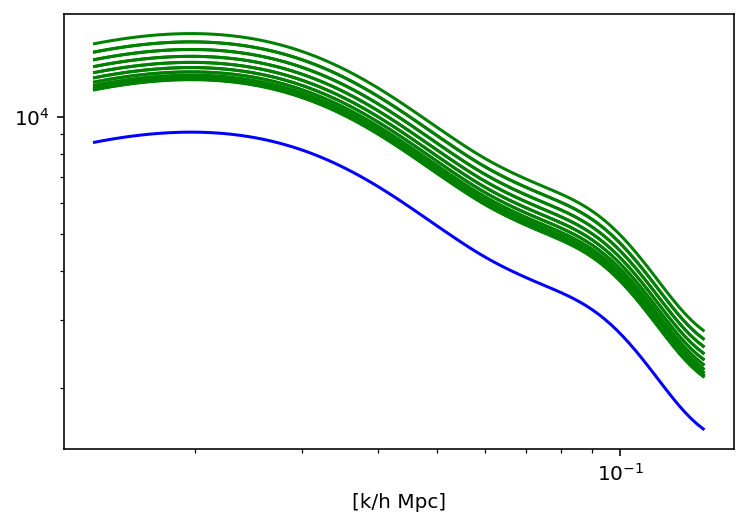

In [111]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[6027.80154103 5928.62073929 5828.97962618 5728.90293334 5628.41802084
 5527.5497279  5426.32132451 5324.75937801 5222.89382592 5120.75574772
 5018.37585088 4915.78804557 4813.02973697 4710.14037954 4607.15802469
 4504.12328292 4401.08033356 4298.0763667  4195.15874358 4092.37673299
 3989.78290592 3887.43288832 3785.38433935 3683.69685319 3582.43254311
 3481.65581914 3381.43412725 3281.83840519 3182.94087397 3084.81451191
 2987.53449156 2891.1825978  2795.8409558  2701.58992938 2608.50921593
 2516.68761725 2426.21534855 2337.17723568 2249.65312539 2163.73051061
 2079.50220275 1997.05162396 1916.45244077 1837.78050744 1761.12337436
 1686.55645326 1614.14064594 1543.92904479 1475.98493095 1410.36050046
 1347.09093964 1286.19902449 1227.72155567 1171.69209178 1118.12496046
 1067.01698197 1018.33979995  972.04340575  928.07024743  886.35729868
  846.85723359  809.55781404  774.43906588  741.46949705  710.57311918
  681.57456631  654.29800168  628.58515721  604.29230001  581.28830361
  559.

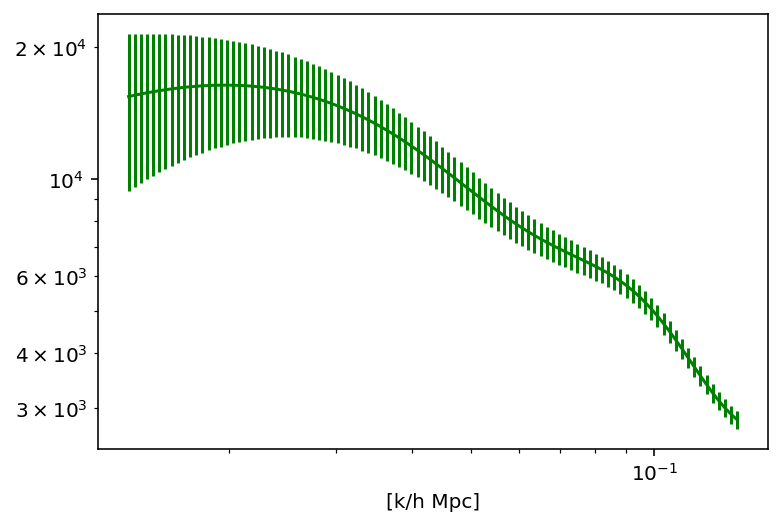

In [112]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [113]:
gammas= np.arange(0,2,0.005)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



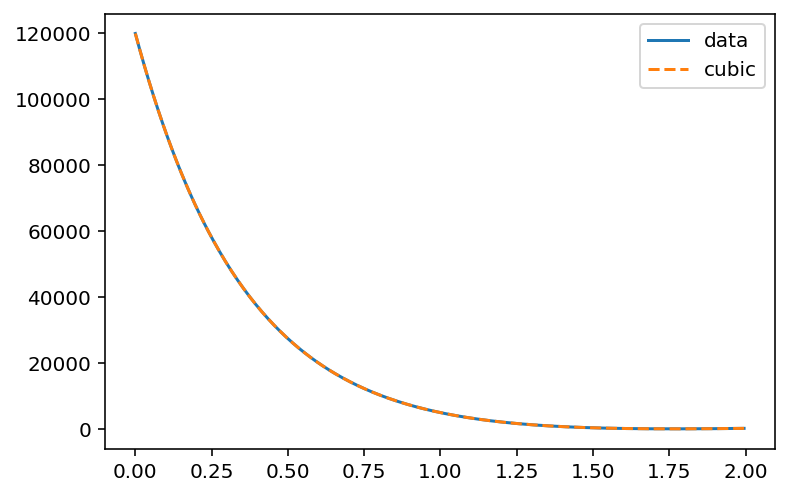

In [114]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])


#plt.axis([0.54,0.56,0,0.4e9])

In [115]:
type(interpol)
y=lambda x: interpol(x)


In [116]:

minimo = optimize.least_squares(y,0.55)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 1.3711109992151466e-15
         fun: array([5.23662296e-08])
        grad: array([-2.15594572e-09])
         jac: array([[-0.04117054]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 21
        njev: 21
  optimality: 2.1559457225274245e-09
      status: 1
     success: True
           x: array([1.76160566])

In [117]:
chi2min= y(min1)

In [118]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

1.76

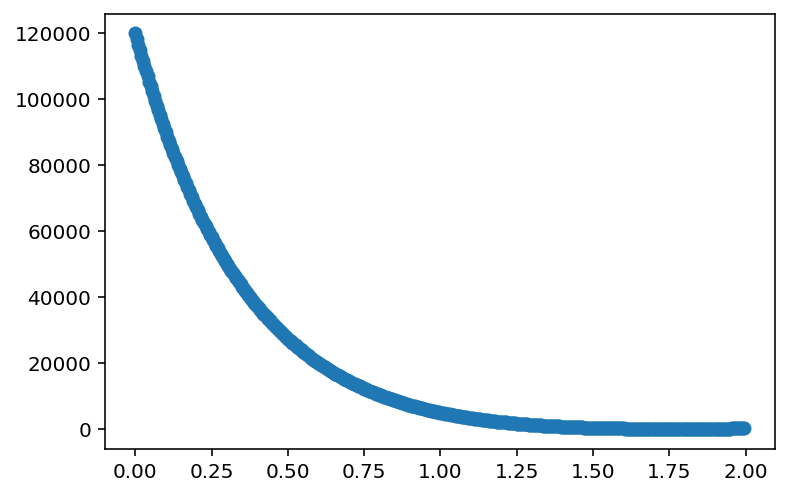

In [119]:
plt.scatter(gammas,chi2)

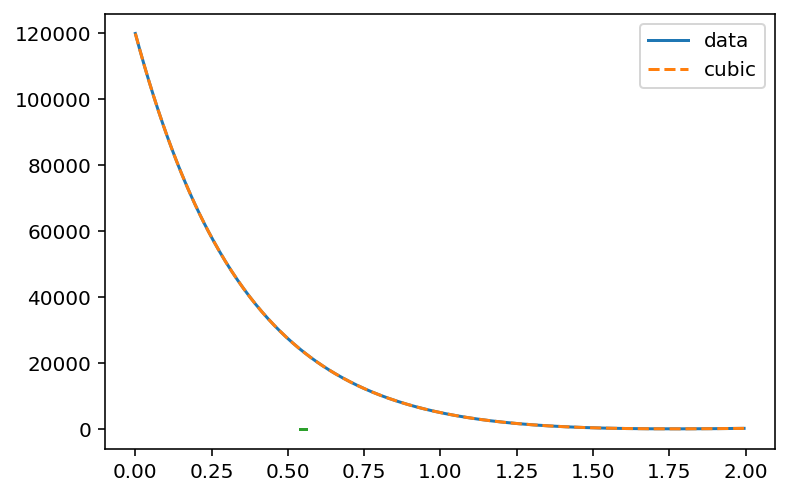

In [120]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.54,0.56,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [121]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.54,0.55)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,0.55,0.56)
print(error1,error2)

ValueError: f(a) and f(b) must have different signs

In [ ]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.006

In [ ]:
print("Il valore di gamma trovat è: ", round(min1,3) ," +- ", sigma)

In [ ]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu


In [ ]:


fit, ax = plt.subplots()

#.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(Z, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori